<a href="https://colab.research.google.com/github/Guillem96/activity-recognition/blob/master/notebooks/Dense%20Trajectories%20Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Action Recognition by Dense Trajectories

In this notebook, we go through a simple implmentation of the trajectory descriprors defined in [Action Recognition by Dense Trajectories](https://hal.inria.fr/inria-00583818/document).

In the follwing cells, we describe how:

1. We densely, sample points from an image.
2. We track points between two frames and how we extend this to a sequence of $L$ frames.
3. Describe the trajectories so them encode *good motion semantics*   

To demonstrate that our Dense Trajectories implementation works as expected, we download the famous taxis sequence dataset.


In [1]:
!rm -rf taxi
!curl -O ftp://ftp.ira.uka.de/pub/vid-text/image_sequences/taxi/taxi.zip
!unzip -q taxi.zip
!rm taxi.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1454k  100 1454k    0     0   421k      0  0:00:03  0:00:03 --:--:--  421k


In [2]:
#@markdown `import *`
from pathlib import Path

import cv2 as cv
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

In [3]:
#@markdown Utilities

def display_video(images, fig=None):
    if fig is None:
        fig = plt.figure()
        
    plt.axis('off')
    im = plt.imshow(images[0], cmap='gray')
    plt.close()

    def init():
        im.set_data(images[0])

    def animate(i):
        im.set_data(images[i])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(images), interval=50)
    display(HTML(anim.to_html5_video()))


In [4]:
taxis_fnames = sorted(list(Path('taxi').iterdir()))
print(f'Number of frames: {len(taxis_fnames)}')

Number of frames: 41


## Sampling points

Dense sampling has shown to improve results over sparse interest points for image classification. The same has been observed for action recognition, where dense sampling at regular positions in space and time outperforms state-of-the-art space-time interest point detectors.

In [5]:
!wget https://www.rubiks.com/static/version1592243066/frontend/Bestresponse/rubiks/en_GB/images/success_rubiks_popup.png

--2021-07-08 16:03:04--  https://www.rubiks.com/static/version1592243066/frontend/Bestresponse/rubiks/en_GB/images/success_rubiks_popup.png
Resolving www.rubiks.com (www.rubiks.com)... 151.101.1.124, 151.101.65.124, 151.101.129.124, ...
Connecting to www.rubiks.com (www.rubiks.com)|151.101.1.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1007088 (983K) [image/png]
Saving to: ‘success_rubiks_popup.png’

success_rubiks_popu 100%[===================>] 983.48K  --.-KB/s    in 0.06s   

2021-07-08 16:03:04 (16.6 MB/s) - ‘success_rubiks_popup.png’ saved [1007088/1007088]



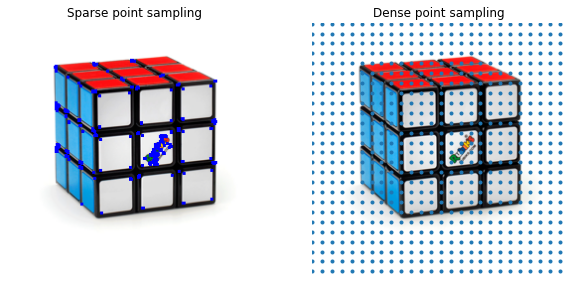

In [6]:
rubik_im = Image.open('success_rubiks_popup.png').convert('RGB')
rubik_im = rubik_im.resize((256, 256))

im_arr = np.array(rubik_im)
gray = cv.cvtColor(im_arr, cv.COLOR_RGB2GRAY)
gray = gray.astype('float32')

dst = cv.cornerHarris(gray, 2, 3, 0.04)
dst = cv.dilate(dst, None)

sparse_im = im_arr.copy()
sparse_im[dst > 0.02 * dst.max()] = [0, 0, 255]

plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(sparse_im)
plt.axis('off')
plt.title('Sparse point sampling')

plt.subplot(122)
plt.scatter(*np.meshgrid(range(0, 256, 10), range(0, 256, 10)), marker='.')
plt.imshow(im_arr)
plt.axis('off')
plt.title('Dense point sampling');

Back in time, to track features over a sequence of frames, the community was mainly using [KLT Tracker](https://en.wikipedia.org/wiki/Kanade%E2%80%93Lucas%E2%80%93Tomasi_feature_tracker). Initially, it was designed to track sparse points, which makes it incompatible with dense sampling. Therefore, Wang et. al. decided to use Dense Optical flow.

## Tracking points

### Tracking point between 2 images


Sample 2 frames of the sequence with a stride of 3, thus the optical flow will be larger, making the plots more clearer

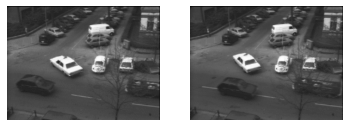

In [7]:
rand_idx = np.random.randint(len(taxis_fnames) - 10, size=(1,)).item()

taxi1 = Image.open(taxis_fnames[rand_idx])
taxi2 = Image.open(taxis_fnames[rand_idx + 10])

plt.subplot(121)
plt.imshow(taxi1, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(taxi2, cmap='gray')
plt.axis('off');

In [8]:
flow = cv.calcOpticalFlowFarneback(np.array(taxi1), 
                                   np.array(taxi2), 
                                   None, 0.7, 8, 15, 15, 5, 1.2, 0)

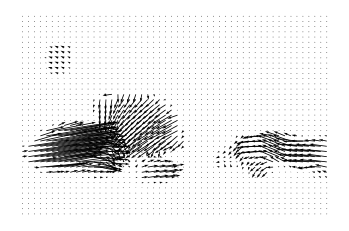

In [9]:
plt.quiver(np.arange(0, 256, 5), np.arange(190, -1, -5),
           flow[::5, ::5, 0], flow[::5, ::5, 1])
plt.axis('off');

Feature points are densely sampled on a grid spaced by $W$ pixels and tracked in each scale separately (Here for simplicity, we only use a single scale). Experimentally, we observed that a sampling step size of
$W = 5$ is dense enough to give good results.

In [10]:
W = 5
pt = np.array(
    np.meshgrid(range(0, taxi1.size[1], W), range(0, taxi1.size[0], W)))

The feature point $P_t$ at time $t$ is $(x_t, y_t)$. We find the same feature point at the next frame $t+1$ using the following expression:

$ P_{t + 1} = (x_{t + 1}, y_{t+1}) = (x_{t}, y_{t}) + (M * w)$

Where $M$ is the median filtering and $w$ is the optical flow $(\vec{u}, \vec{v})$ resulting from the intensity equation $I(x_t, y_t, t) = I(x_t + u, y_t + v, t + 1)$ 

In [11]:
pt = pt.transpose((1, 2, 0))
pt_1 = pt + np.flip(cv.medianBlur(flow, 3)[pt[...,0], pt[...,1]], -1)

We plot samples of trajectories

In [12]:
pt = pt.reshape(-1, 2)
pt_1 = pt_1.reshape(-1, 2)

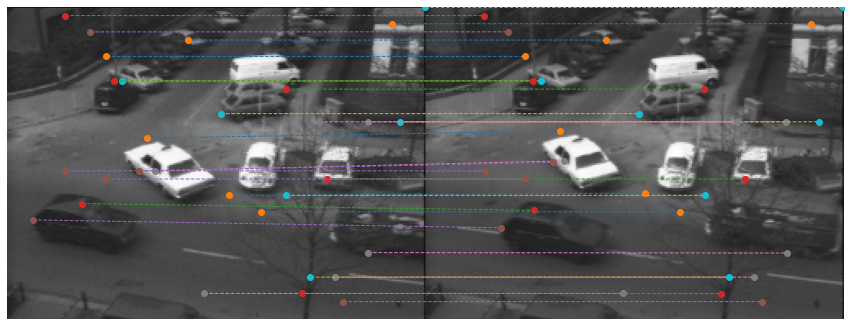

In [13]:
rand_samples = np.random.randint(0, 
                                 high=pt.shape[0], 
                                 size=(30,))
complete_image = np.concatenate([np.array(taxi1), np.array(taxi2)], axis=1)

plt.figure(figsize=(15, 15))
plt.imshow(complete_image, cmap='gray')
plt.axis('off')
for point1, point2 in zip(pt[rand_samples], pt_1[rand_samples]):
    plt.plot([point1[1], point2[1] + taxi1.size[0]], 
             [point1[0], point2[0]], '--', linewidth=1)
    plt.plot([point1[1], point2[1] + taxi1.size[0]], 
             [point1[0], point2[0]], 'o')

### Tracking a points in video

When tracking video points, we suffer from driffting. Trajectories
tend to drift from their initial location during tracking. To
avoid this problem, we limit the length of a trajectory to L
frames.

In [14]:
L = 15 #@param {"type": "slider", "min": 3, "max": 20 }

In [15]:
rand_idx = np.random.randint(0, high=len(taxis_fnames) - L, size=(1,)).item()
images = [Image.open(o) for o in taxis_fnames[rand_idx: rand_idx + L]]
display_video(images)

Sample the initial points to track

In [16]:
pt = np.array(
    np.meshgrid(range(0, taxi1.size[1], W), range(0, taxi1.size[0], W)))

fig = plt.figure(figsize=(8, 4))
plt.scatter(pt[1], pt[0], marker='.')
display_video(images, fig=fig)

Compute optical flow for each pair of frames


In [17]:
def compute_of(frame1, frame2):
    return cv.calcOpticalFlowFarneback(np.array(frame1), 
                                       np.array(frame2), 
                                       None, 0.7, 8, 15, 15, 5, 1.2, 0)

ofs = [compute_of(a, b) for a, b in zip(images[:-1], images[1:])]

Again, we plot a simplified version of our sequence. Making the resulting plots simplier to understand.

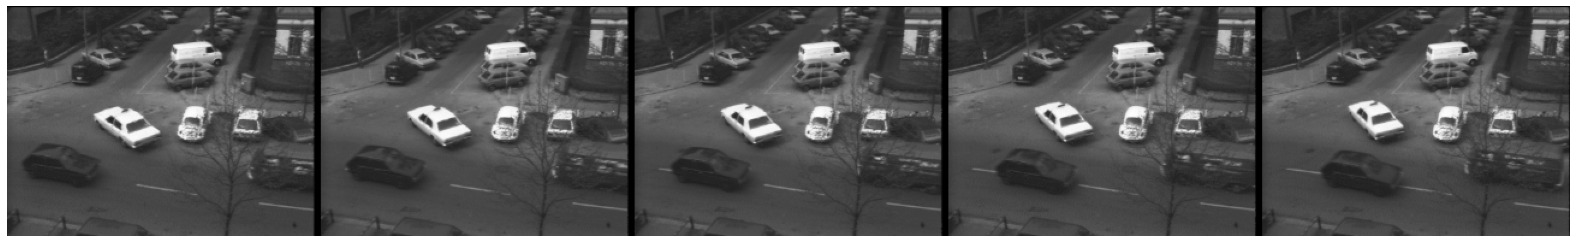

In [18]:
def plot_sequence(images, stride=3, margin=5):
    l = len(images)
    n_ims = l // stride
    if l % 2 == 1 and stride % 2 == 0:
        n_ims += 1
    final_im = np.zeros((images[0].size[1], 
                         images[0].size[0] * n_ims + margin * (n_ims - 1)))
    for i, im in enumerate(images[::stride]):
        start_w = i * taxi1.size[0] + margin * i
        end_w = start_w + taxi1.size[0]
        final_im[:, start_w: end_w] = np.array(im)

    plt.imshow(final_im, cmap='gray')
    plt.axis('off');

plt.figure(figsize=(28, 28))
plot_sequence(images)

In [19]:
points = [pt.transpose((1, 2, 0))]
for of in ofs:
    pt = points[-1].astype('int32')
    pt_1 = pt + np.flip(cv.medianBlur(flow, 3)[pt[...,0], pt[...,1]], -1)
    points.append(pt_1)

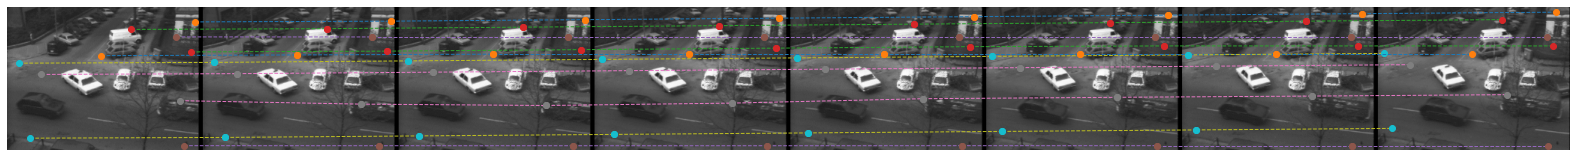

In [20]:
margin = 5
stride = 2

plt.figure(figsize=(28, 28))
plot_sequence(images, margin=margin, stride=stride)

points = [o.reshape(-1, 2) for o in points]
ds_points = points[::stride]
rand_samples = np.random.randint(0, high=ds_points[0].shape[0], size=(10,))

for i, (pfi, pfj) in enumerate(zip(ds_points[:-1], ds_points[1:])):

    start_w = i * taxi1.size[0] + i * margin
    w_offset = margin + taxi1.size[0]
    for point1, point2 in zip(pfi[rand_samples], pfj[rand_samples]):
        plt.plot([point1[1] + start_w, point2[1] + start_w + w_offset], 
                 [point1[0], point2[0]], '--', linewidth=1)
        plt.plot([point1[1] + start_w, point2[1] + start_w + w_offset], 
                 [point1[0], point2[0]], 'o')

The shape of a trajectory encodes local motion patterns.
Given a trajectory of length $L$, we describe its shape by a
sequence $S = \Delta P_1 + \Delta P_2 + ... + \Delta P_L$ where $\Delta P_t = P_{t+1} - P_t$.



In [21]:
S = [p_t1 - p_t for p_t, p_t1 in zip(points[:-1], points[1:])]
S = np.array(S) 
S /= np.sum(np.linalg.norm(S, axis=(1, 2)))

We refer the resulting vector by trajectory descriptor.

## Encode trajectories

In this section we obtain motion information for the computed dense trajectories,we compute descriptors within a space-time volume ($N \times N \times L )$ around the trajectory. 

To keep the volume structure, we divide it in a  spatial-temporal grid of size $\eta_{\sigma} \times \eta_{\sigma} \times \eta_{\tau} $.

![](https://static-01.hindawi.com/articles/cin/volume-2016/6750459/figures/6750459.fig.004.svgz)

The descriptors computed for each subgrid are:

- **Histogram of Gradients**
- **Histogram of Optical Flow**
- **Motion Boundaries Histogram (MBH)**